1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [154]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
                            precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

Выполним загрузку и первоначальные инициализации:

In [3]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Exited'), df['Exited'], random_state=0)

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [166]:
def metrics(y, pred_proba):
    precision, recall, thresholds = precision_recall_curve(y, pred_proba)

    fscore = (2 * precision * recall) / (precision + recall)
    y_scale = (np.logspace(0, 1, fscore.shape[0]) - 1) / 9

    plt.plot(thresholds, recall[:-1], label='recall')
    plt.plot(thresholds, precision[:-1], label='precision')
    plt.plot(thresholds, fscore[:-1], label='f-score')
    plt.legend(loc='best')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.show()
    ix = np.argmax(fscore[~np.isnan(fscore)])
    return 'Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                             fscore[ix],
                                                                             precision[ix],
                                                                             recall[ix])


def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if classes is None:
        classes = ['NonChurn', 'Churn']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Базовые преобразования, проводимые ранее:

In [155]:
final_transformers = list()

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

In [168]:
feats.fit(X_train)
X_train_tr = feats.transform(X_train)
X_test_tr = feats.transform(X_test)

-----
Далее обучим несколько моделей и сделаем расчет экономической эффективности из оценки, что 1 денежная единица тратится на привлечение каждого нового клиента, 2 денежные единицы - на удержание каждого предсказанного. При этому $n$ единиц идет в прибыль с каждого активного (предположим, что каждый клиент вносит одинаковый вклад).

В общем случае экономическая эфективность будет равна:

$$\text{efficiency} = (TP + TN + FP) \cdot n - (TP + FP) \cdot 2 - FN \cdot 1$$,
где:
* $TP$ - клиенты, потенциально уходящие в отток, но которых удалось перехватить;
* $TN$ - клиенты, не собирающиеся уходить, которых не пытаются удержать;
* $FP$ - клиенты, не уходящие потенциально в отток, но на которых потратились для попытки предотвращения оттока;
* $FN$ - клиенты, действительно ушедшие в отток, которых не удалось перехватить (то есть их необходимо искать заново).

----
### Градиентный бустинг

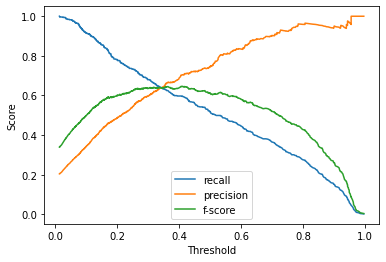

'Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597'

In [169]:
gboost_model = GradientBoostingClassifier()
gboost_model.fit(X_train_tr, y_train)
pred_train = gboost_model.predict_proba(X_train_tr)[:, 1]
pred_test = gboost_model.predict_proba(X_test_tr)[:, 1]
metrics(y_test, pred_test)

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


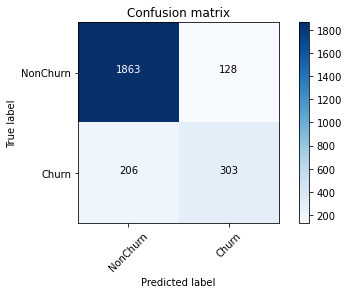

In [170]:
plot_confusion_matrix(confusion_matrix(y_test, np.where(pred_test > 0.408508, 1, 0)))

В данном случае экономическая эффективность будет равна: $\text{efficiency} = (303 + 1863 + 128) \cdot n - (303 + 128) \cdot 2 - 206 = 2294n - 1068$

---
### Логистическая регрессия

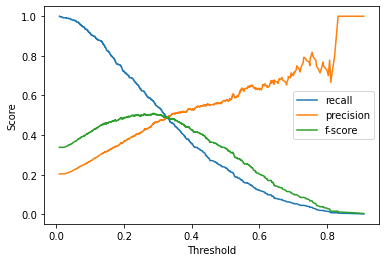

'Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568'

In [171]:
log_model = LogisticRegression()
log_model.fit(X_train_tr, y_train)
pred_train = log_model.predict_proba(X_train_tr)[:, 1]
pred_test = log_model.predict_proba(X_test_tr)[:, 1]
metrics(y_test, pred_test)

Предварительно метрики модели логистической регрессии по всем типам выглядят хуже, чем у градиентного бустинга. Рассмотрим более подробно экономические показатели.

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


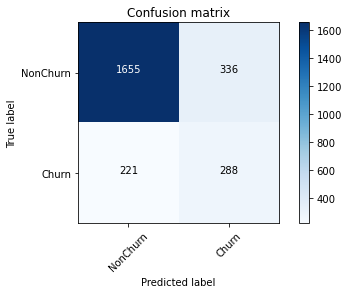

In [172]:
plot_confusion_matrix(confusion_matrix(y_test, np.where(pred_test > 0.289522, 1, 0)))

В данном случае экономическая эффективность будет равна: $\text{efficiency} = (288 + 1655 + 336) \cdot n - (288 + 336) \cdot 2 - 221 = 2279n - 1469$

----

Также рассмотрим случай, когда никакая бы модель не применялась:

В тестовой выборке 2500 клиентов, из которых уходят в отток 509, а остаются 1991. То есть экономическая эффективность такого случая равна: $\text{efficiency} = 1991 \cdot n - 509$

Сейчас оценим конечную эффективность в завивимости от доходности клиента (например, до 10 денежных единиц):

In [194]:
2294 - 1991

303

In [196]:
559 / 303

1.844884488448845

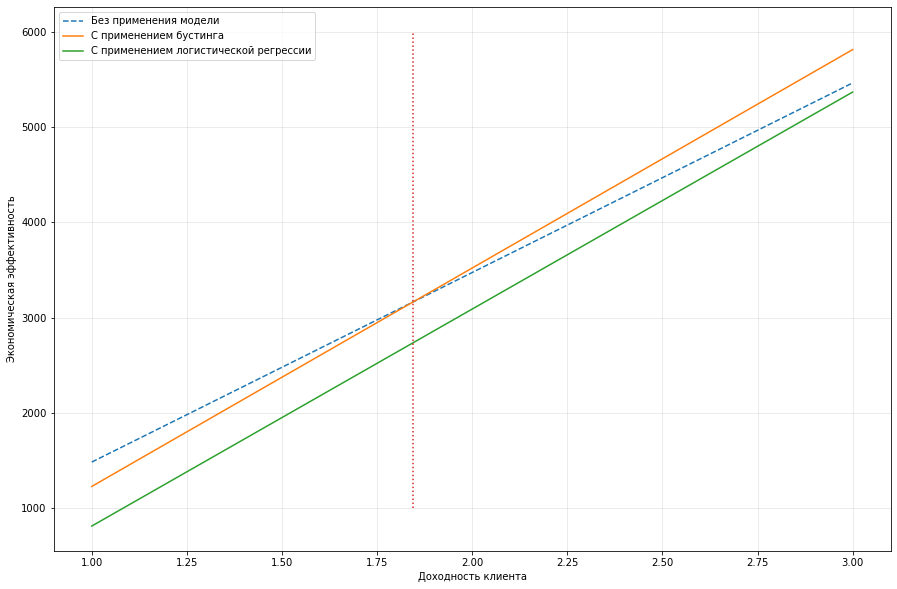

In [206]:
x_range = np.linspace(1, 3, 100)

wo_model = x_range * 1991 - 509
xg_model = x_range * 2294 - 1068
log_model = x_range * 2279 - 1469

plt.figure(figsize=(15, 10))
plt.plot(x_range, wo_model, label='Без применения модели', ls='--')
plt.plot(x_range, xg_model, label='С применением бустинга')
plt.plot(x_range, log_model, label='С применением логистической регрессии')
plt.plot([1.8448, 1.8448], [1000, 6000], ls=':')
plt.legend(loc='best')
plt.xlabel('Доходность клиента')
plt.ylabel('Экономическая эффективность')
plt.grid(alpha=0.3)
plt.show()

Таким образом можно сделать вывод, что с выбранным порогом модель логистической регрессии будет всегда менее выгодна, чем модель градиентного бустинга, поэтому первую можно отбросить.

Далее видно, что при средней доходности клиента от $\approx1.85$ выгоднее применять модель градиентного бустинга, в ином случае выгоднее ничего не предпринимать и пытаться искать новых клиентов.